**!!! PLEASE UPVOTE THE KERNEL IF YOU LIKE IT !!!**

# Introduction:
The American Society of Heating, Refrigerating and Air-Conditioning Engineers ([ASHRAE](https://en.wikipedia.org/wiki/ASHRAE)) is an American professional association seeking to advance heating, ventilation, air conditioning and refrigeration systems design and construction. ASHRAE has more than 57,000 members in more than 132 countries worldwide. 

# Problem Statement : 

Significant investments are being made to improve building efficiencies to reduce costs and emissions. But, are the improvements working? Current methods of estimation are fragmented and do not scale well. Some assume a specific meter type or don’t work with different building types.

In this competition, you’ll develop accurate predictions of metered building energy usage in the following areas: chilled water, electric, natural gas, hot water, and steam meters. The data comes from over 1,000 buildings over a three-year timeframe.

# Analysis:

Here, we will start working with the datasets and try to build some understanding about the same first using certain visualizations. Then we will see if we can do some feature engineering and try to build some model.

First, we import necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

Next, we list the input files to see that there are 6 files available.

In [2]:
print(os.listdir('../input/ashrae-energy-prediction'))

['sample_submission.csv', 'building_metadata.csv', 'weather_test.csv', 'train.csv', 'test.csv', 'weather_train.csv']


# Training Data

# a) train.csv

### Step 1) Reading and Interpreting Data

Because there are 6 files, reading them individually and then interpreting them one by one will make the code longer. So, I have written a small function to help me for this task.

In [3]:
# Function to read and do the initial data interpretation
def read_and_interpret_data(filename):
    path = "../input/ashrae-energy-prediction"
    df = pd.read_csv('{0}/{1}'.format(path,filename))
    print("~~~~~~Shape of the data~~~~~~ : ",df.shape)
    print("~~~~~~Columns and their datatype~~~~~~ : ")
    print(df.info())
    print("~~~~~~Quick Look at the data~~~~~~ : ")
    print(df.head())
    print("~~~~~~Description of the data~~~~~~ : ")
    print(df.describe())
    print("~~~~~~NAs present in the data~~~~~~ : ")
    print(df.isna().sum())
    if 'timestamp' in df.columns: 
        df['timestamp'] = pd.to_datetime(df['timestamp'],format = "%Y-%m-%d %H:%M:%S")
        print("~~~~~~Year of the data~~~~~~ :")
        print(df.timestamp.dt.year.unique())
    return df

In [4]:
df_train = read_and_interpret_data('train.csv')

~~~~~~Shape of the data~~~~~~ :  (20216100, 4)
~~~~~~Columns and their datatype~~~~~~ : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB
None
~~~~~~Quick Look at the data~~~~~~ : 
   building_id  meter            timestamp  meter_reading
0            0      0  2016-01-01 00:00:00            0.0
1            1      0  2016-01-01 00:00:00            0.0
2            2      0  2016-01-01 00:00:00            0.0
3            3      0  2016-01-01 00:00:00            0.0
4            4      0  2016-01-01 00:00:00            0.0
~~~~~~Description of the data~~~~~~ : 
        building_id         meter  meter_reading
count  2.021610e+07  2.021610e+07   2.021610e+07
mean   7.992780e+02  6.624412e-01   2.117121e+03
std    4.269133e+02  9.309921e-01   1.532356e+05
min    0.000

In [5]:
df_train.groupby('building_id')['meter_reading'].agg(['count','min','max','mean','median','std'])
# We can see that the values for building number 1099 are exceptionally high. These can be safely considered as outliers and can be dropped.

,count,min,max,mean,median,std
building_id,,,,,,
0,8784,0.000,448.000,146.454978,189.7520,121.897171
1,8784,0.000,255.000,74.865393,95.0124,61.765389
2,8784,0.000,67.983,14.551385,9.4193,16.063792
3,8784,0.000,937.000,235.549966,315.6840,205.985852
4,8784,0.000,3592.000,976.556746,1450.4400,779.694100
...,...,...,...,...,...,...
1444,7445,0.000,35.825,7.482127,6.6750,4.386412
1445,7449,2.400,10.850,4.732815,4.8250,1.317669
1446,7472,0.000,15.300,3.592162,0.0000,4.531993


In [6]:
df_train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [7]:
# Remove outliers
df_train = df_train [df_train['building_id'] != 1099 ]
df_train = df_train.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

### Step 2) Visualizing Data

In [8]:
start = df_train['timestamp'].min()
end = df_train['timestamp'].max()

In [9]:
type(start)

pandas._libs.tslibs.timestamps.Timestamp

We are interested to see how the target variable varies with time. 

For this, I have implemented a function that lets us look at the data. 

The beauty of this function is that -
- By default, this function plots the whole data starting from building_id = 0 to `num_buildings` specified
- If provided the start and end data, it will plot the data between this specified period.
- If provided with parameter `start_building`, it will plot from building_id = `start_building` onwards

In [10]:
def plot_for_date_range(num_buildings,start_building = 0,start_date=start, end_date=end):
    plt.figure(figsize=(18,15), facecolor='white')
    plot_num = 1
    for i in range(start_building,start_building+num_buildings):
        ax = plt.subplot(num_buildings, 1, plot_num)
        data=df_train[df_train.building_id == i].set_index('timestamp').loc[start_date:end_date]
        data.plot(y='meter_reading', ax=ax, label=i, legend=False)
        ax.set_title(f'Building id {i}')
        plot_num +=1
    
    plt.tight_layout()

**1) Variation of Target Variable `meter_reading` with `timestamp` - For the whole year 2016**

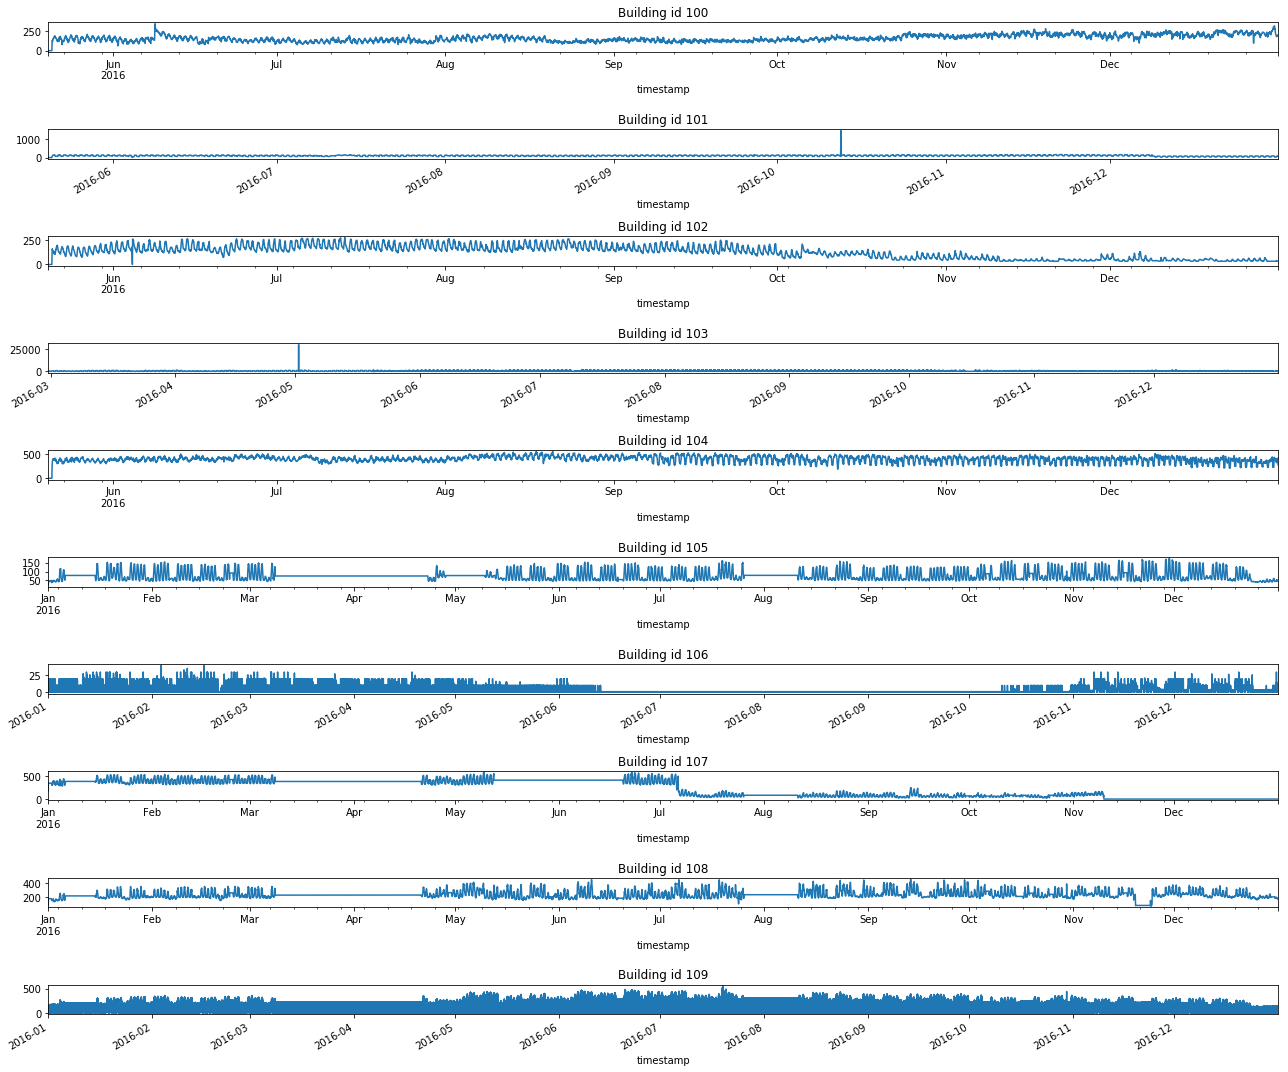

In [11]:
plot_for_date_range(num_buildings = 10,start_building = 100)

From the above graph, we note the following -

General Trend
 - meter reading is very low from Jan to April in general but for some building it is not true
 - There is a sudden spike in May after which the meter reading goes again to very low.
 - From mid-June onwards, the meter_reading follows a noisy time series

** 2) Target variable with time - Specified Range**

Although, the above graph lets us visualize how `meter_reading` varies over the year 2016 as a whole, we are unable to visualize the seasonal changes in the graph.

For this, we can use the same function by passing the start and end dates between which we are interested to see the graph

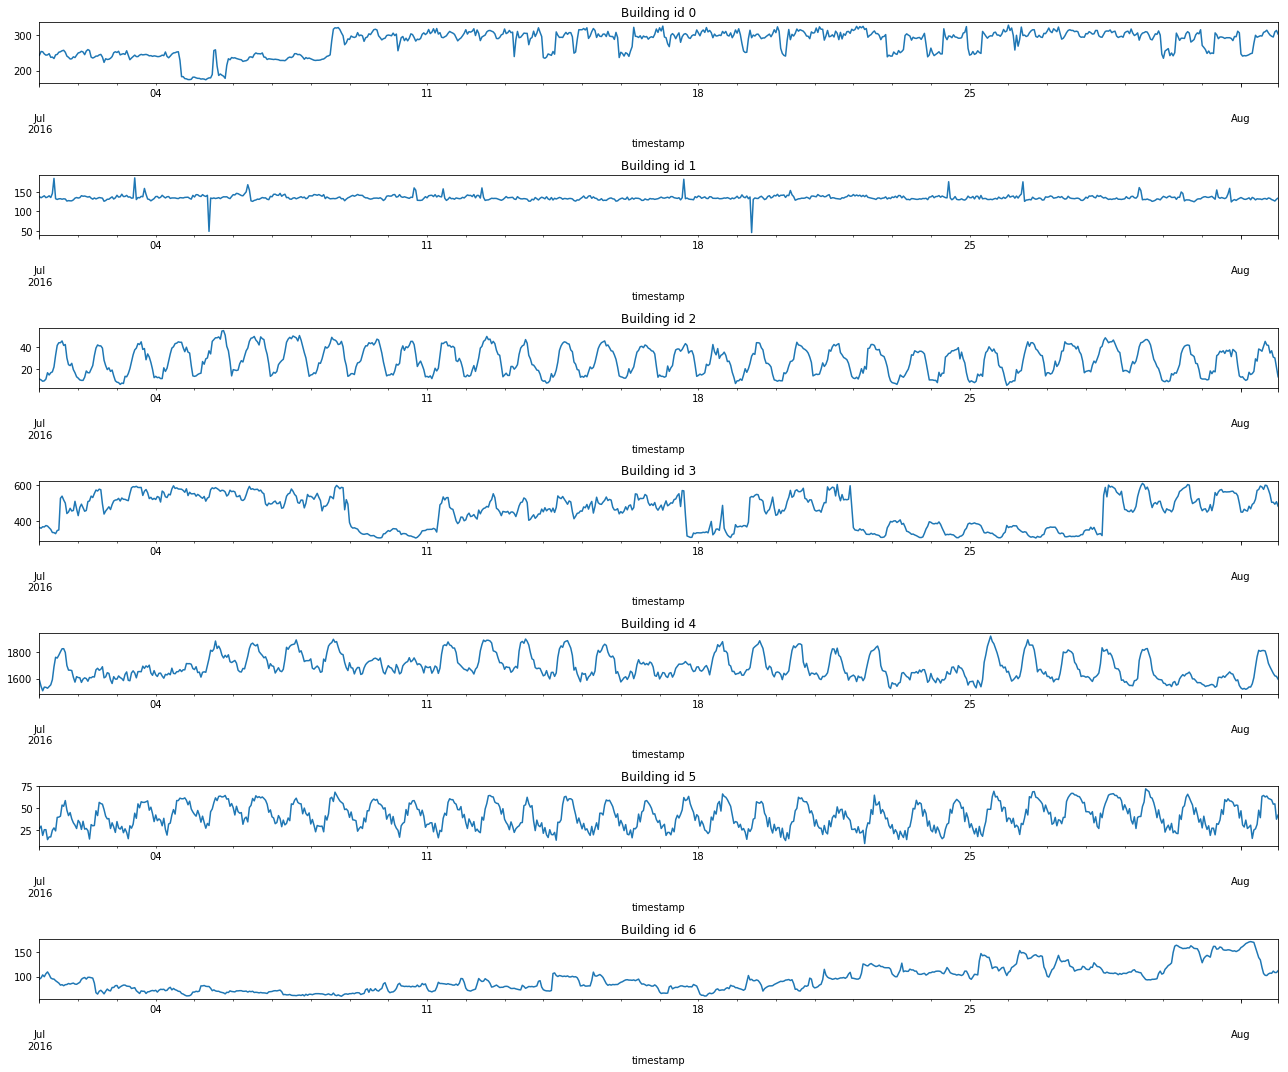

In [12]:
plot_for_date_range(7,0,'2016-07-01', '2016-08-01')

Specific Notes
 - For Buildings 2 and 5, we can clearly see that there is a daily seasonality pattern in the data i.e. the meter readings are very low during early morning and night time whereas it peaks during the daytime. I think this pattern denotes a household or a small company which switches off its energy requirements during these wee hours.
 
 - For Building Id 1, we can see that the meter reading is very much constant throughout the day and it keeps on for most of the days. In between there are sudden up-spikes and downspikes. This kind of pattern suggests this building must be a powerplant or a computer data center which needs continuous supply of energy. The spikes might suggest sudden energy surge or server downtime. 
 
 - For other buildings, there is no identifiable pattern.

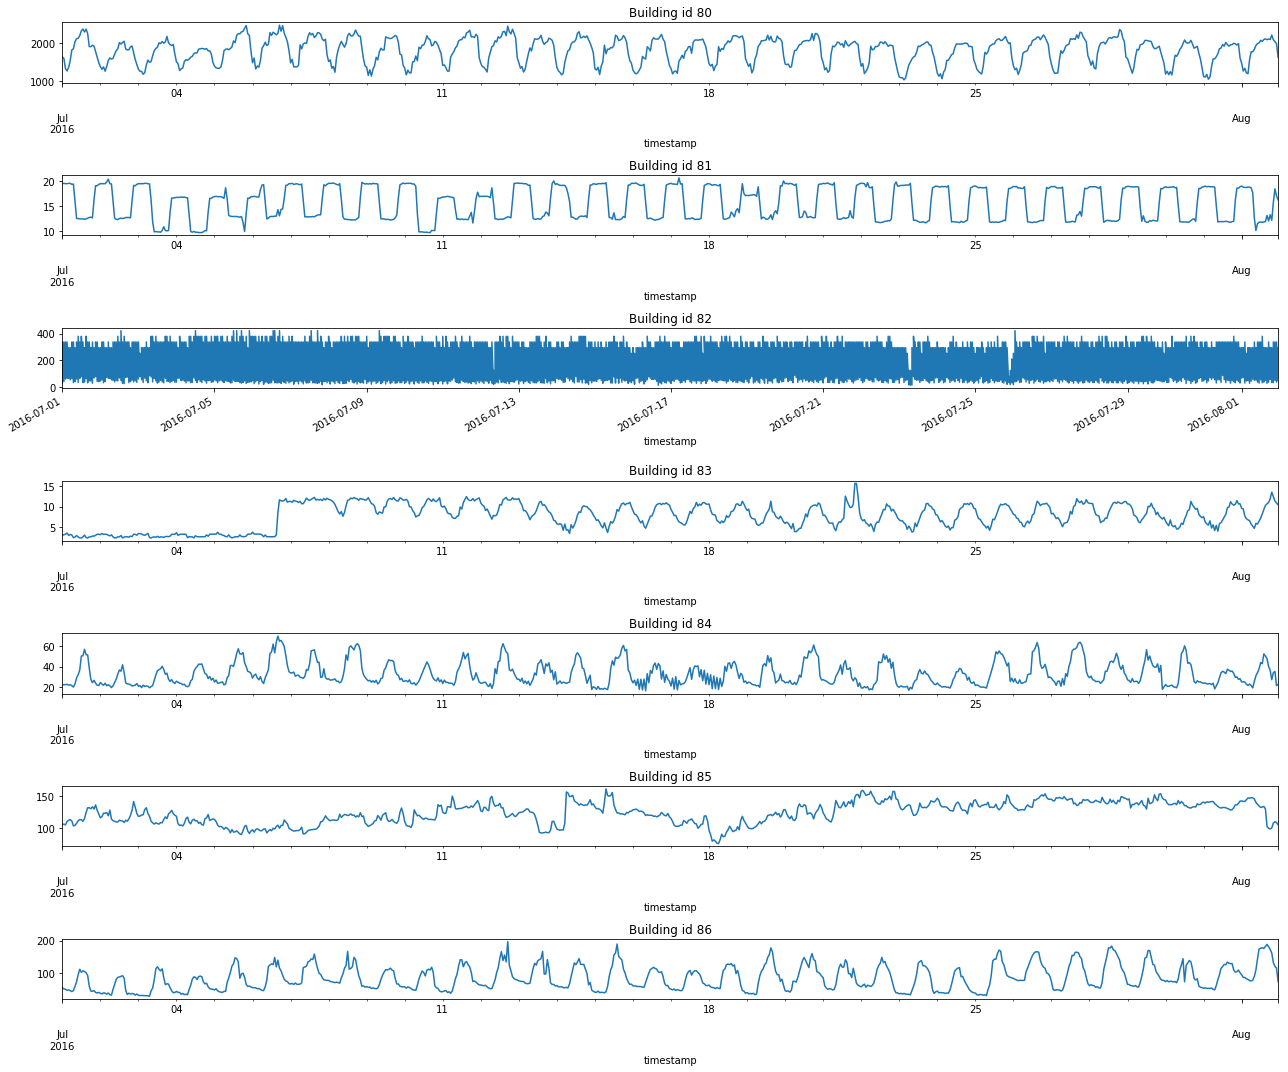

In [13]:
plot_for_date_range(7,80,'2016-07-01', '2016-08-01')

### Step 3) Feature Engineering

In [14]:
df_train['month'] = df_train['timestamp'].dt.month
df_train['dayofweek'] = df_train['timestamp'].dt.dayofweek
df_train['hourofday'] = df_train['timestamp'].dt.hour

### Step 4) Reducing memory usage

In [15]:
# Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [16]:
df_train = reduce_mem_usage(df_train)

Mem. usage decreased to 492.25 Mb (59.4% reduction)


# b) building_metadata.csv

### Step 1) Reading and Interpreting Data

In [17]:
df_building_metadata = read_and_interpret_data('building_metadata.csv')

~~~~~~Shape of the data~~~~~~ :  (1449, 6)
~~~~~~Columns and their datatype~~~~~~ : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB
None
~~~~~~Quick Look at the data~~~~~~ : 
   site_id  building_id primary_use  square_feet  year_built  floor_count
0        0            0   Education         7432      2008.0          NaN
1        0            1   Education         2720      2004.0          NaN
2        0            2   Education         5376      1991.0          NaN
3        0            3   Education        23685      2002.0          NaN
4        0            4   Education       116607      1975.0          NaN
~~~~~~Description of the data~~~~~~ : 
       

### Step 2) Visualizing Data

In [18]:
def plot_hist(df,var_name):
    plt.figure(figsize=(17,8))
    plt.hist(df[var_name],bins = 50)
    plt.title(f"Histogram - {var_name}")
    plt.show()

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


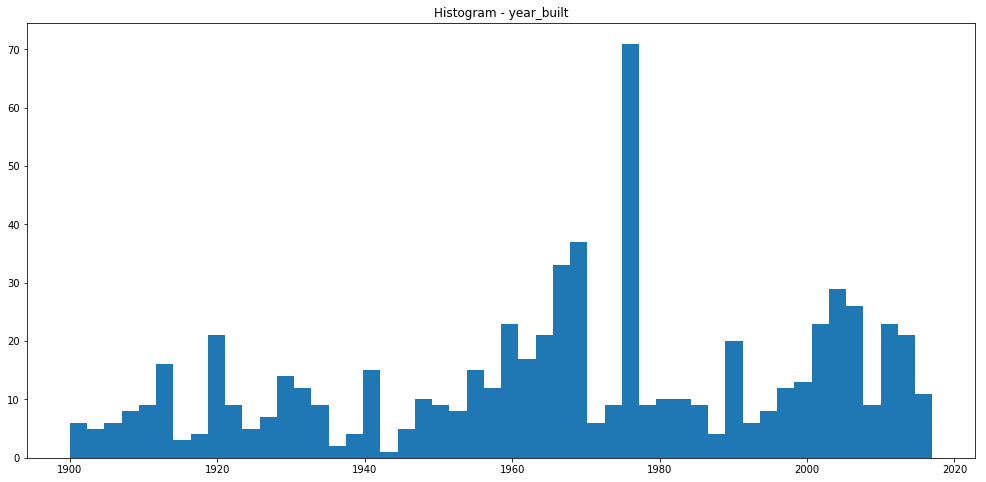

In [19]:
plot_hist(df_building_metadata,'year_built')

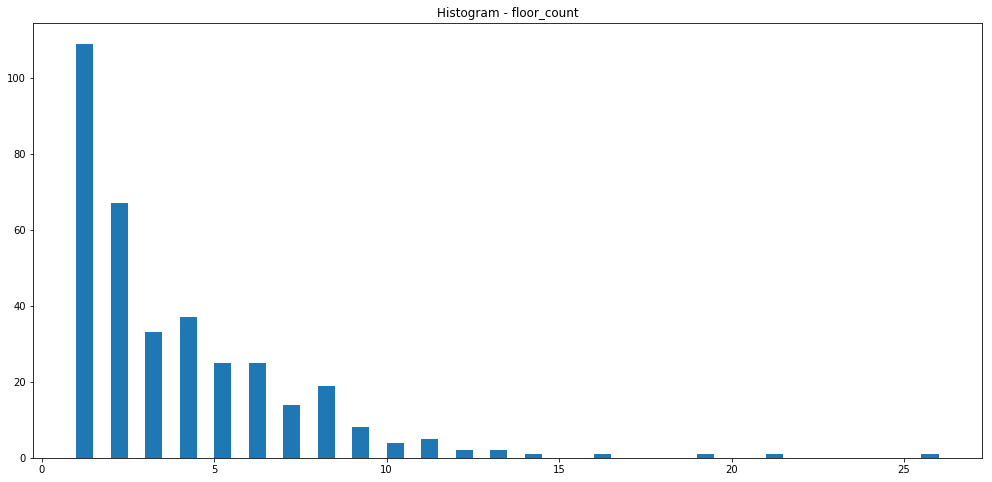

In [20]:
plot_hist(df_building_metadata,'floor_count')

### Step 3) Removing NAs

We can see that there are 774 NA values out of 1449 rows in the `year_built` column. (50% NA)

Problem : If we impute all NA values with a single value(either mean, median or mode), this is going to significantly distort the distribution.

Solution : For now, let's remove these two columns altogether to simplify things. Later we will try some other strategies for imputation.

In [21]:
# df_building_metadata = df_building_metadata.drop(['year_built','floor_count'],axis = 1)

### Step 3.1) Imputation

In [22]:
import random
def fill_building_data(df, col):
    df_notna = df[df[col].notnull()]
    df_na = df[~df[col].notnull()]
    filler_list = df[col].value_counts().index.tolist()[0:5]
    df_na[col] = random.choices(filler_list,k = len(df_na))
    print(df_na.head())
    print(df_na.isna().sum())
    return pd.concat([df_na,df_notna],axis=0).sort_values("building_id")

In [23]:
# df_building_metadata = fill_building_data(df_building_metadata,'year_built')

In [24]:
# df_building_metadata = fill_building_data(df_building_metadata,'floor_count')

In [25]:
df_building_metadata.describe()

,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.000000,355.000000
mean,6.952381,724.000000,92111.776398,1967.957037,3.740845
std,5.003432,418.434583,110769.950997,31.054030,3.333683
min,0.000000,0.000000,283.000000,1900.000000,1.000000
25%,3.000000,362.000000,23012.000000,1949.000000,1.000000
50%,5.000000,724.000000,57673.000000,1970.000000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.000000,5.000000
max,15.000000,1448.000000,875000.000000,2017.000000,26.000000


In [26]:
df_building_metadata.isna().sum()

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

In [27]:
df_building_metadata['year_built'].value_counts()

1976.0    55
1966.0    23
1968.0    18
1919.0    17
1964.0    15
          ..
1934.0     1
1936.0     1
1926.0     1
2017.0     1
1947.0     1
Name: year_built, Length: 116, dtype: int64

In [28]:
df_building_metadata['year_built'].fillna(1976, inplace = True)

In [29]:
df_building_metadata['floor_count'].fillna(1, inplace = True)

### Step 4) Encode Categorical Data

In [30]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_building_metadata["primary_use"] = le.fit_transform(df_building_metadata["primary_use"])

### Step 4) Reducing memory usage

In [31]:
df_building_metadata = reduce_mem_usage(df_building_metadata)

Mem. usage decreased to  0.02 Mb (74.9% reduction)


# c) weather_train.csv

### Step 1) Reading and Interpreting Data

In [32]:
df_weather_train = read_and_interpret_data('weather_train.csv')

~~~~~~Shape of the data~~~~~~ :  (139773, 9)
~~~~~~Columns and their datatype~~~~~~ : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null object
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB
None
~~~~~~Quick Look at the data~~~~~~ : 
   site_id            timestamp  air_temperature  cloud_coverage  \
0        0  2016-01-01 00:00:00             25.0             6.0   
1        0  2016-01-01 01:00:00             24.4             NaN   
2        0  2016-01-01 02:00:00             22.8             2.0   
3        0  2016-

### Step 2) - Visualizing Data

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


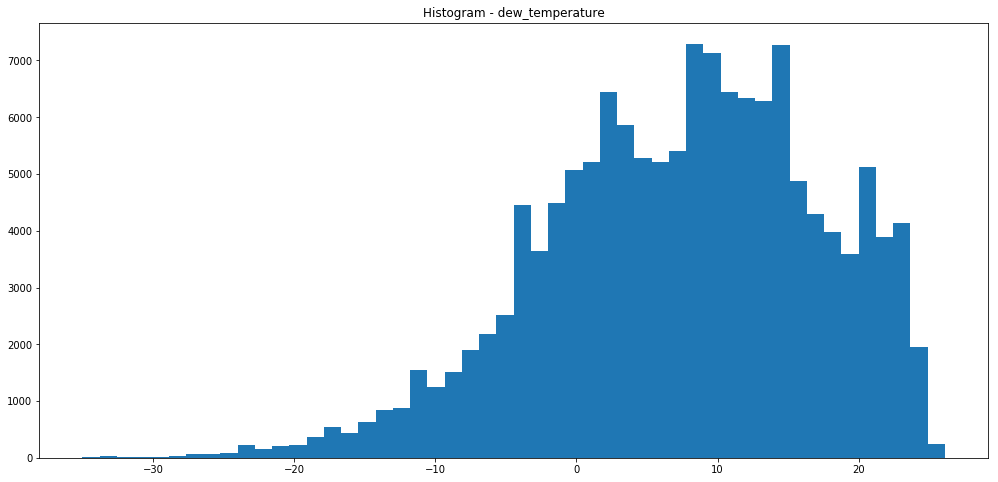

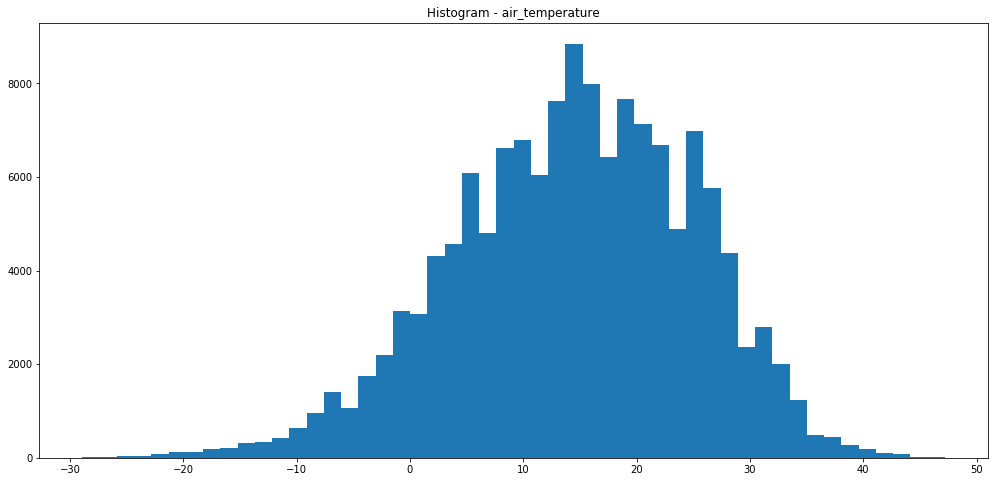

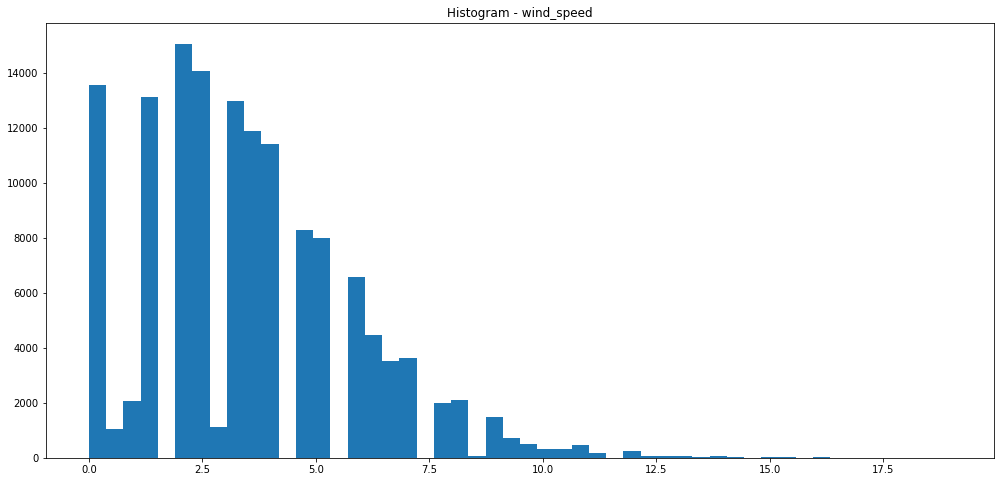

In [33]:
for var in ['dew_temperature','air_temperature','wind_speed']:
    plot_hist(df_weather_train,var)

### Step 3) Handling NAs

** a) Removing columns which have lot of NAs **

In [34]:
import datetime
def fill_weather_dataset(weather_df):
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
#     start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
#     end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    start_date = weather_df['timestamp'].min().to_pydatetime()
    end_date = weather_df['timestamp'].max().to_pydatetime()
#     total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
#     hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = np.array([(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)])

    missing_hours = []
    for site_id in range(16):
        
        site_tot_hrs = df_weather_train[df_weather_train['site_id'] == 1]['timestamp']
        site_hours = np.array([x.strftime(time_format) for x in site_tot_hrs])
#         site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    # AIR TEMPERATURE
    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # CLOUD COVERAGE
    # Step 1
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])
    weather_df.update(cloud_coverage_filler,overwrite=False)

    # DEW TEMPERATURE
    dew_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(dew_temperature_filler,overwrite=False)

    # SEA LEVEL PRESSURE
    # Step 1
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])

    weather_df.update(sea_level_filler,overwrite=False)

    # WIND DIRECTION
    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    # WIND SPEED
    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # PRECIPITATION DEPTH
    # Step 1
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler,overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
        
    return weather_df

def limit_dew_temp(air_temp, dew_temp):
    if dew_temp > air_temp:
        return air_temp
    else:
        return dew_temp

In [35]:
df_weather_train = fill_weather_dataset(df_weather_train)
df_weather_train['dew_temperature'] = df_weather_train.apply(lambda x: limit_dew_temp(x.air_temperature, x.dew_temperature), axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [36]:
# drop_cols = ['cloud_coverage','precip_depth_1_hr','sea_level_pressure','wind_direction']
# df_weather_train = df_weather_train.drop(drop_cols,axis =1)

In [37]:
df_weather_train.head()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,timestamp,wind_direction,wind_speed
0,0,25.0,6.000000,20.0,-0.173913,1019.7,2016-01-01 00:00:00,0.0,0.0
1,0,24.4,4.285714,21.1,-1.000000,1020.2,2016-01-01 01:00:00,70.0,1.5
2,0,22.8,2.000000,21.1,0.000000,1020.2,2016-01-01 02:00:00,0.0,0.0
3,0,21.1,2.000000,20.6,0.000000,1020.1,2016-01-01 03:00:00,0.0,0.0
4,0,20.0,2.000000,20.0,-1.000000,1020.0,2016-01-01 04:00:00,250.0,2.6


** b) Imputing with the median value **

In [38]:
df_weather_train.head()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,timestamp,wind_direction,wind_speed
0,0,25.0,6.000000,20.0,-0.173913,1019.7,2016-01-01 00:00:00,0.0,0.0
1,0,24.4,4.285714,21.1,-1.000000,1020.2,2016-01-01 01:00:00,70.0,1.5
2,0,22.8,2.000000,21.1,0.000000,1020.2,2016-01-01 02:00:00,0.0,0.0
3,0,21.1,2.000000,20.6,0.000000,1020.1,2016-01-01 03:00:00,0.0,0.0
4,0,20.0,2.000000,20.0,-1.000000,1020.0,2016-01-01 04:00:00,250.0,2.6


In [39]:
df_weather_train.isna().sum()

site_id               0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
timestamp             0
wind_direction        0
wind_speed            0
dtype: int64

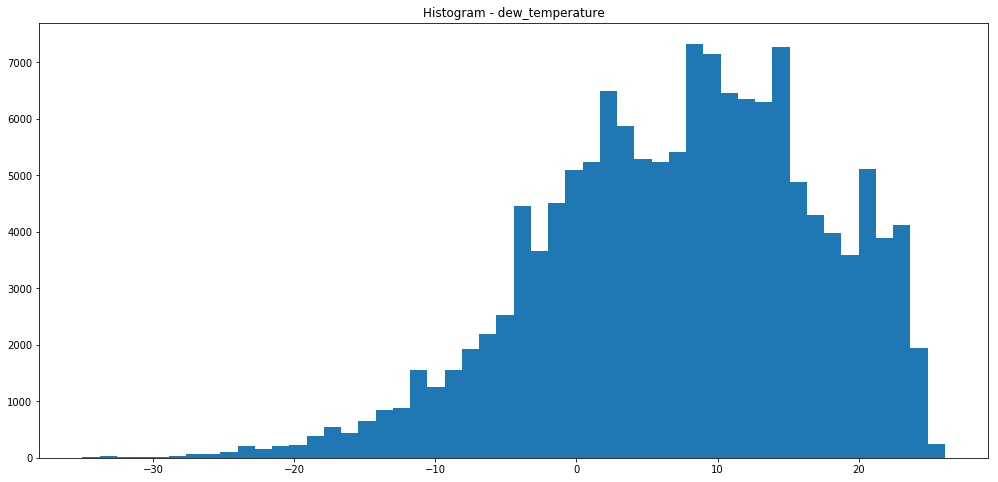

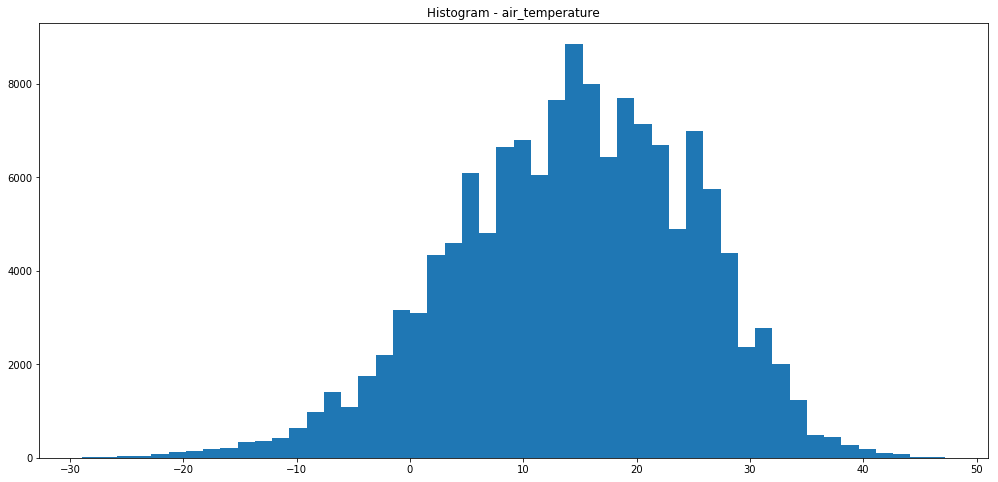

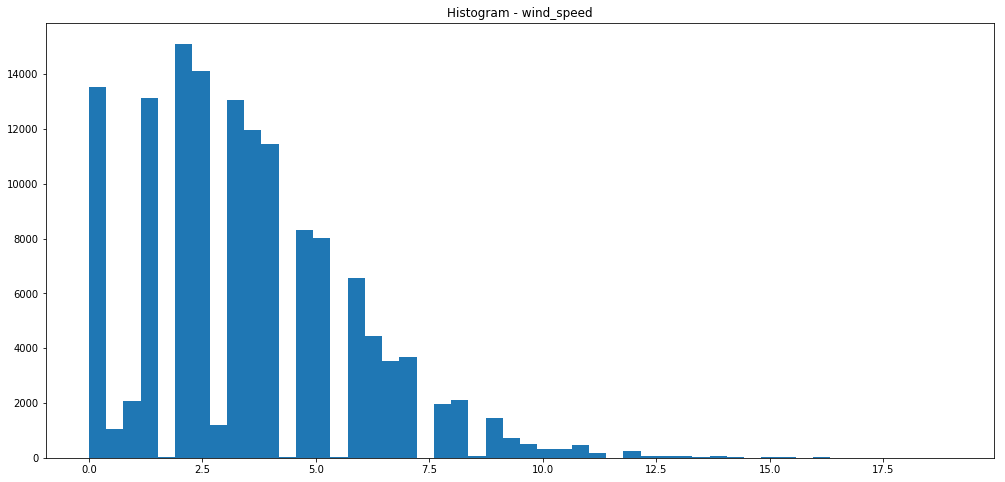

In [40]:
# Visualizing distributions after median imputations
for var in ['dew_temperature','air_temperature','wind_speed']:
    plot_hist(df_weather_train,var)

Observation - 

We can confirm from the histograms above that the imputation performed did not change the variable distribution very much as there were very less rows having NA values. So we are good.

### Step 4) Reducing memory usage

In [41]:
df_weather_train = reduce_mem_usage(df_weather_train)

Mem. usage decreased to  3.07 Mb (68.1% reduction)


# Prepare Training Data

Here, we notice that `df_train` dataset does not have many features available. But other datasets `df_weather_train` and `df_meta` have features which we can use to build model. So, we prepare training data by joining these 3 datasets. This way, we will have features available in the same place in one dataset.

In [42]:
train_df = pd.merge(df_train,df_building_metadata,on = 'building_id')
# train_df.head()

In [43]:
df_weather_train['timestamp'] = pd.to_datetime(df_weather_train['timestamp'])
train_df = pd.merge(train_df,df_weather_train,on = ['site_id','timestamp'])

In [44]:
train_df['square_feet'] =  np.log1p(train_df['square_feet'])

In [45]:
import gc
target = np.log1p(train_df["meter_reading"])
features = train_df.drop('meter_reading', axis = 1)
del df_train, df_weather_train, train_df
gc.collect()

14735

In [46]:
features=features.drop("timestamp",axis = 1)

In [47]:
features.isna().sum()

building_id           0
meter                 0
month                 0
dayofweek             0
hourofday             0
site_id               0
primary_use           0
square_feet           0
year_built            0
floor_count           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

In [48]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19805120 entries, 0 to 19805119
Data columns (total 17 columns):
building_id           int16
meter                 int8
month                 int8
dayofweek             int8
hourofday             int8
site_id               int8
primary_use           int8
square_feet           float64
year_built            float16
floor_count           float16
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
dtypes: float16(9), float64(1), int16(1), int8(6)
memory usage: 793.3 MB


In [49]:
[var for var in dir() if isinstance(eval(var), pd.core.frame.DataFrame)]

['_25', '_37', '_38', '_5', '_6', 'df_building_metadata', 'features']

# LGBM Model

In [50]:
import lightgbm as lgb
from sklearn.model_selection import KFold

In [51]:
categorical_features = ["building_id", "site_id", "meter", "primary_use", "dayofweek","month","hourofday"]
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

kf = KFold(n_splits=3)
models = []
for train_index,test_index in kf.split(features):
    train_features = features.loc[train_index]
    train_target = target.loc[train_index]
    
    test_features = features.loc[test_index]
    test_target = target.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models.append(model)
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.13881	valid_1's rmse: 1.54982
[50]	training's rmse: 0.890297	valid_1's rmse: 1.55545
Early stopping, best iteration is:
[21]	training's rmse: 1.23079	valid_1's rmse: 1.5483
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.966837	valid_1's rmse: 1.81002
[50]	training's rmse: 0.737224	valid_1's rmse: 1.77602
[75]	training's rmse: 0.674552	valid_1's rmse: 1.77023
[100]	training's rmse: 0.637856	valid_1's rmse: 1.76759
[125]	training's rmse: 0.611623	valid_1's rmse: 1.76586
[150]	training's rmse: 0.591624	valid_1's rmse: 1.76441
[175]	training's rmse: 0.57756	valid_1's rmse: 1.76565
[200]	training's rmse: 0.567633	valid_1's rmse: 1.76413
[225]	training's rmse: 0.559436	valid_1's rmse: 1.76257
[250]	training's rmse: 0.552254	valid_1's rmse: 1.76198
[275]	training's rmse: 0.545793	valid_1's rmse: 1.76187
[300]	training's rmse: 0.540163	valid_1's rmse: 1.76222
[325]	trainin

In [52]:
del features, target
gc.collect()

0

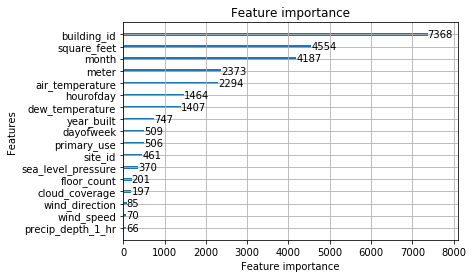

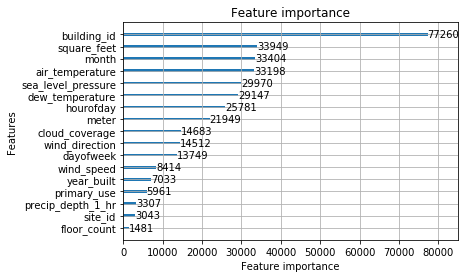

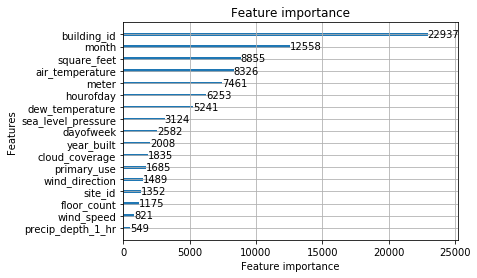

In [53]:
for model in models:
    lgb.plot_importance(model)
    plt.show()

# Decision Tree Regression Model

In [54]:
#Import the regression tree model
# from sklearn.tree import DecisionTreeRegressor
# regression_model = DecisionTreeRegressor(criterion="mse",min_samples_leaf=5)

In [55]:
#Fit the model
# x_train = train_df.drop(['meter_reading','timestamp'],axis = 1)
# y_train = train_df['meter_reading']
# regression_model.fit(x_train,y_train)

In [56]:
# x_train.isna().sum()

In [57]:
#Predict on Training Data
# predicted_train = regression_model.predict(x_train)

Training Error -

In [58]:
#Compute the RMSLE
# def RMSLE(pred,act): 
#     return np.sqrt(np.sum((np.log(pred+1)-np.log(act+1))**2)/len(act))

In [59]:
# Training Error
# RMSLE(predicted_train,y_train)

In [60]:
# Checking Actual and Predicted values side by side
# pd.DataFrame(zip(y_train,predicted_train),columns = ['Actual','Predicted']).iloc[2000000:10000000,].head(10)

# Testing Data

# a) test.csv

### Step 1) Reading and Interpreting Data

In [61]:
df_test = read_and_interpret_data('test.csv')

~~~~~~Shape of the data~~~~~~ :  (41697600, 4)
~~~~~~Columns and their datatype~~~~~~ : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 4 columns):
row_id         int64
building_id    int64
meter          int64
timestamp      object
dtypes: int64(3), object(1)
memory usage: 1.2+ GB
None
~~~~~~Quick Look at the data~~~~~~ : 
   row_id  building_id  meter            timestamp
0       0            0      0  2017-01-01 00:00:00
1       1            1      0  2017-01-01 00:00:00
2       2            2      0  2017-01-01 00:00:00
3       3            3      0  2017-01-01 00:00:00
4       4            4      0  2017-01-01 00:00:00
~~~~~~Description of the data~~~~~~ : 
             row_id   building_id         meter
count  4.169760e+07  4.169760e+07  4.169760e+07
mean   2.084880e+07  8.075824e+02  6.642857e-01
std    1.203706e+07  4.297680e+02  9.278067e-01
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    1.042440e+07  4.047500e+02 

### Step 2) Reducing memory usage

In [62]:
df_test = reduce_mem_usage(df_test)

Mem. usage decreased to 596.49 Mb (53.1% reduction)


### Step 3) Feature Engineering

In [63]:
df_test['month'] = df_test['timestamp'].dt.month
df_test['dayofweek'] = df_test['timestamp'].dt.dayofweek
df_test['hourofday'] = df_test['timestamp'].dt.hour

In [64]:
# df_test.head()

In [65]:
# df_test.info()

In [66]:
df_test = reduce_mem_usage(df_test)

Mem. usage decreased to 715.79 Mb (53.8% reduction)


# b) weather_test.csv

### Step 1) Reading and Interpreting Data

In [67]:
df_weather_test = read_and_interpret_data('weather_test.csv')

~~~~~~Shape of the data~~~~~~ :  (277243, 9)
~~~~~~Columns and their datatype~~~~~~ : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277243 entries, 0 to 277242
Data columns (total 9 columns):
site_id               277243 non-null int64
timestamp             277243 non-null object
air_temperature       277139 non-null float64
cloud_coverage        136795 non-null float64
dew_temperature       276916 non-null float64
precip_depth_1_hr     181655 non-null float64
sea_level_pressure    255978 non-null float64
wind_direction        264873 non-null float64
wind_speed            276783 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 19.0+ MB
None
~~~~~~Quick Look at the data~~~~~~ : 
   site_id            timestamp  air_temperature  cloud_coverage  \
0        0  2017-01-01 00:00:00             17.8             4.0   
1        0  2017-01-01 01:00:00             17.8             2.0   
2        0  2017-01-01 02:00:00             16.1             0.0   
3        0  20

### Step 2) - Visualizing Data

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


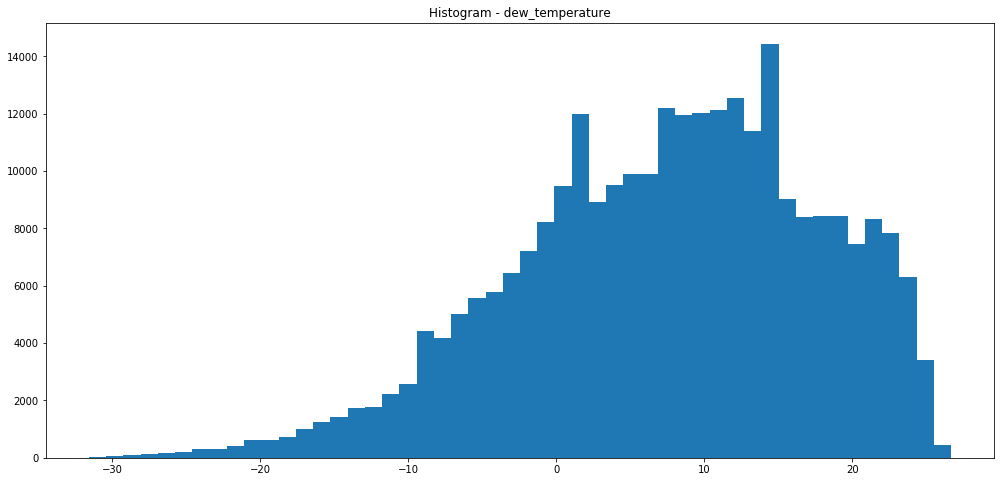

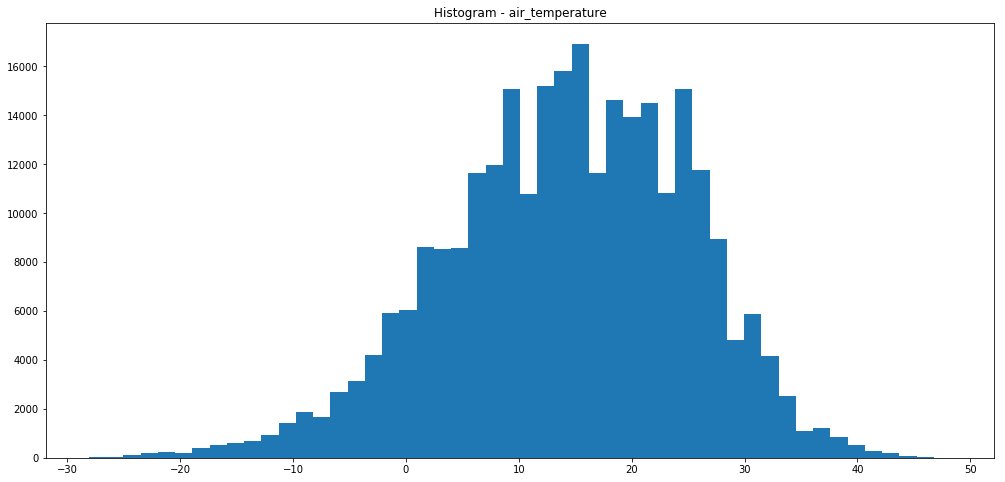

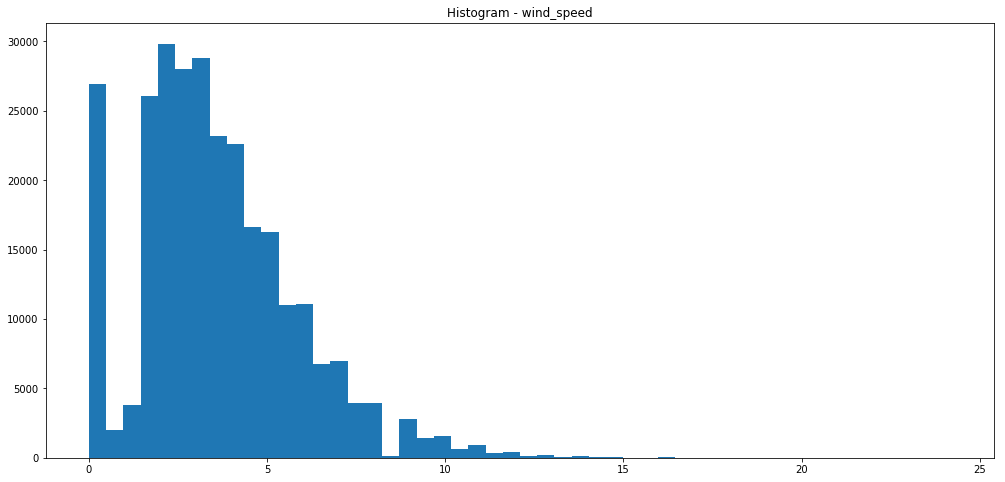

In [68]:
for var in ['dew_temperature','air_temperature','wind_speed']:
    plot_hist(df_weather_test,var)

### Step 3) Handling NAs

** a) Removing columns which have lot of NAs **

In [69]:
# drop_cols = ['cloud_coverage','precip_depth_1_hr','sea_level_pressure','wind_direction']
# df_weather_test = df_weather_test.drop(drop_cols,axis =1)

In [70]:
df_weather_test.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6


In [71]:
# df_weather_test.isna().sum()

** b) Imputing with the median value **

In [72]:
# df_weather_test.fillna(df_weather_test.median(),inplace=True)

In [73]:
# df_weather_test.head()

In [74]:
df_weather_test.isna().sum()

site_id                    0
timestamp                  0
air_temperature          104
cloud_coverage        140448
dew_temperature          327
precip_depth_1_hr      95588
sea_level_pressure     21265
wind_direction         12370
wind_speed               460
dtype: int64

In [75]:
# Visualizing distributions after median imputations
# for var in ['dew_temperature','air_temperature','wind_speed']:
#     plot_hist(df_weather_test,var)

Observation - 

We can confirm from the histograms above that the imputation performed did not change the variable distribution very much as there were very less rows having NA values. So we are good.

# Prepare Testing Data

Same as before, we join `df_test` , `df_weather_test` and `df_meta` to have features available in the same place in one dataset.

In [76]:
test_df = pd.merge(df_test,df_building_metadata,on = 'building_id')

test_df = pd.merge(test_df,df_weather_test,on = ['site_id','timestamp'],how='left')

In [77]:
test_df = reduce_mem_usage(test_df)

Mem. usage decreased to 1988.30 Mb (45.7% reduction)


In [78]:
[var for var in dir() if isinstance(eval(var), pd.core.frame.DataFrame)]

['_25',
 '_37',
 '_38',
 '_5',
 '_6',
 '_70',
 '__',
 'df_building_metadata',
 'df_test',
 'df_weather_test',
 'test_df']

In [79]:
del df_test, df_weather_test, df_building_metadata
gc.collect()

27642

In [80]:
row_ids = test_df['row_id']
test_df = test_df.drop(['timestamp','row_id'],axis = 1)

In [81]:
test_df["square_feet"] = np.log1p(test_df["square_feet"])

In [82]:
test_df.fillna(test_df.median(),inplace=True)

In [83]:
test_df.head()

,building_id,meter,month,dayofweek,hourofday,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,1,6,0,0,0,8.913685,2008.0,1.0,17.796875,4.0,11.703125,0.0,1021.5,100.0,3.599609
1,0,0,1,6,1,0,0,8.913685,2008.0,1.0,17.796875,2.0,12.796875,0.0,1022.0,130.0,3.099609
2,0,0,1,6,2,0,0,8.913685,2008.0,1.0,16.093750,0.0,12.796875,0.0,1022.0,140.0,3.099609
3,0,0,1,6,3,0,0,8.913685,2008.0,1.0,17.203125,0.0,13.296875,0.0,1022.0,140.0,3.099609
4,0,0,1,6,4,0,0,8.913685,2008.0,1.0,16.703125,2.0,13.296875,0.0,1022.5,130.0,2.599609


In [84]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 17 columns):
building_id           int16
meter                 int8
month                 int8
dayofweek             int8
hourofday             int8
site_id               int8
primary_use           int8
square_feet           float64
year_built            float16
floor_count           float16
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
dtypes: float16(9), float64(1), int16(1), int8(6)
memory usage: 1.6 GB


In [85]:
test_df.isna().sum()

building_id           0
meter                 0
month                 0
dayofweek             0
hourofday             0
site_id               0
primary_use           0
square_feet           0
year_built            0
floor_count           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

In [86]:
gc.collect()

0

# Predictions

In [87]:
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    del model
    gc.collect()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [88]:
del test_df, models
gc.collect()

0

In [89]:
#Predict on Testing Data
# predicted_test = regression_model.predict(test_df)

In [90]:
# submission_df = pd.DataFrame(zip(row_id,predicted_test),columns = ['row_id','meter_reading'])
results_df = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(results, 0, a_max=None)})
del row_ids,results
gc.collect()
results_df.to_csv("submission_lgbm1.csv", index=False)

In [91]:
# submission_df = submission_df.sort_values(by = 'row_id')

In [92]:
# submission_df.head()

In [93]:
# submission_df.shape

In [94]:
# submission_df.to_csv("ashrae_submit.csv", index=False)

In [95]:
# from IPython.display import FileLink
# FileLink(r'ashrae_submit.csv')

**!!! PLEASE UPVOTE THE KERNEL IF YOU LIKE IT !!!**

STILL IN PROGRESS ....

### Step 3) Handling NA values

### 1. Imputing Year built -

Number of NAs - 

In [96]:
# df_building_metadata['year_built'].isna().sum()

We can see that there are 774 NA values out of 1449 rows in the `year_built` column. (50% NA)

Variable Distribution - 

In [97]:
# plt.figure(figsize=(17,8))
# plt.hist(df_building_metadata['year_built'],bins = 20)
# plt.title("Histogram showing the Distribution of the Year in which Builidings were built")
# plt.show()

Problem : If we impute all NA values with a single value(either mean, median or mode), this is going to significantly distort the distribution.

Solution : From the histograms above, we see that most buildings were built around 1960 - 1975 and 2000 - 2010, so we will impute from this year range.

In [98]:
# Making a list of mode years
# mode_yr1,mode_yr2 = list(range(1960,1975)),  list(range(2000,2010))
# mode_years = mode_yr1 + mode_yr2

In [99]:
# import random
# random.seed(123)

In [100]:
# Replacing NAs by chooosing randomly from the mode years
# nans = df_building_metadata['year_built'].isna()
# length = sum(nans)
# replacement = random.choices(mode_years, k=length)
# df_building_metadata.loc[nans,'year_built'] = replacement

In [101]:
# plt.figure(figsize=(17,8))
# plt.hist(df_building_metadata['year_built'],bins = 20)
# plt.title("Histogram showing the Distribution of the Year in which Builidings were built")
# plt.show()

In [102]:
# plt.figure(figsize=(17,8))
# plt.hist(df_building_metadata['year_built'],bins = 20)
# plt.title("Histogram showing the Distribution of the Year in which Builidings were built")
# plt.show()

Note that the distribution has still increased around the mode years as there were lot of rows which were NA. But we can see it is kind of levelled out

We can again check if there are any null values left out

In [103]:
# df_building_metadata[df_building_metadata.year_built.isnull()]

### 2. Imputing Floor Count -

Number of NAs -

In [104]:
# df_building_metadata['floor_count'].isna().sum()

We can see that there are 1094 NA values out of 1449 rows in the `floor_count` column. (75% NA)

Variable Distribution -

In [105]:
# plt.figure(figsize=(17,8))
# plt.hist(df_building_metadata['floor_count'],bins = 20)
# plt.title("Histogram showing the distribution of number of Floors in Buildings")
# plt.show()

We can see that this is an asymmetric distribution with most of the values taking 1 to 10 values

In [106]:
# Making a list of mode years
# mode_floors = range(10)

In [107]:
# Replacing NAs by chooosing randomly from the mode years
# nans = df_building_metadata['floor_count'].isna()
# length = sum(nans)
# replacement = random.choices(mode_floors, k=length)
# df_building_metadata.loc[nans,'floor_count'] = replacement

In [108]:
# plt.figure(figsize=(17,8))
# plt.hist(df_building_metadata['floor_count'],bins = 20)
# plt.title("Histogram showing the distribution of number of Floors in Buildings")
# plt.show()

In [109]:
# [1,0,np.nan,2].isnull().replace(0)

In [110]:
# nan_yrs = sum(df_building_metadata.year_built.isnull())
# rand_mode_year = random.choices(mode_years, k =nan_yrs)

In [111]:
# df_building_metadata['year_built'].replace(np.nan,rand_mode_year)

In [112]:
# list(range(1960,1975))

In [113]:
# mode_years[0]

In [114]:
# df_building_metadata['year_built'] = df_building_metadata['year_built'].astype('int16')

In [115]:
#df_train['timestamp'].dt.weekday_name.unique()

In [116]:
#df_train['day_of_weak'] = df_train['timestamp'].dt.day

In [117]:
#df_train.building_id.nunique() * 24 * 365 

In [118]:
#df_test = read_and_interpret_data('test.csv')

In [119]:
# df_weather_train = read_and_interpret_data('weather_train.csv')

In [120]:
#df_weather_test = read_and_interpret_data('weather_test.csv')

In [121]:
#df_meta = read_and_interpret_data('building_metadata.csv')

### Step 2) - Reducing Memory Usage
1) From the information above, we can see that `df_train` and `df_test` consume a huge amount of memory (~1GB). But there is a scope to reduce the memory.

2) We notice that the int and float datatypes are 64 bits, which is the underlying cause for this huge size of the datasets. We have a function available to reduce this size.

In [122]:
# Reducing dataframe size
# df_train = reduce_mem_usage(df_train)
# df_test = reduce_mem_usage(df_test)
# df_weather_train = reduce_mem_usage(df_weather_train)
# df_weather_test = reduce_mem_usage(df_weather_test)
# df_meta = reduce_mem_usage(df_meta)

In [123]:
# train_df = df_train.join(df_meta.set_index('building_id'), on = 'building_id')

In [124]:
# train_df.info()

In [125]:
# train_df = train_df.join(df_weather_train.set_index('site_id'), on = 'site_id')

In [126]:
# pr = [0 for x in df_test['row_id'] == df_test.index.tolist()]

In [127]:
# len(pr)

In [128]:
# df_test = df_test.drop('row_id',axis=1)

Step 2) - Note that the data is huge, so in order to be in the kernel limit, we append these two datasets into one.

In [129]:
# df_test['meter_reading'] = 'NA'

In [130]:
# df_test.head()

In [131]:
# df_test_train = pd.concat([df_train,df_test])

In [132]:
# del df_train, df_test

In [133]:
# df_test_train[df_test_train.meter_reading == 'NA'].head()

In [134]:
# df_test_train_meta = df_test_train.join(df_meta.set_index('building_id'), on = 'building_id')
# df_test_train_meta.head()